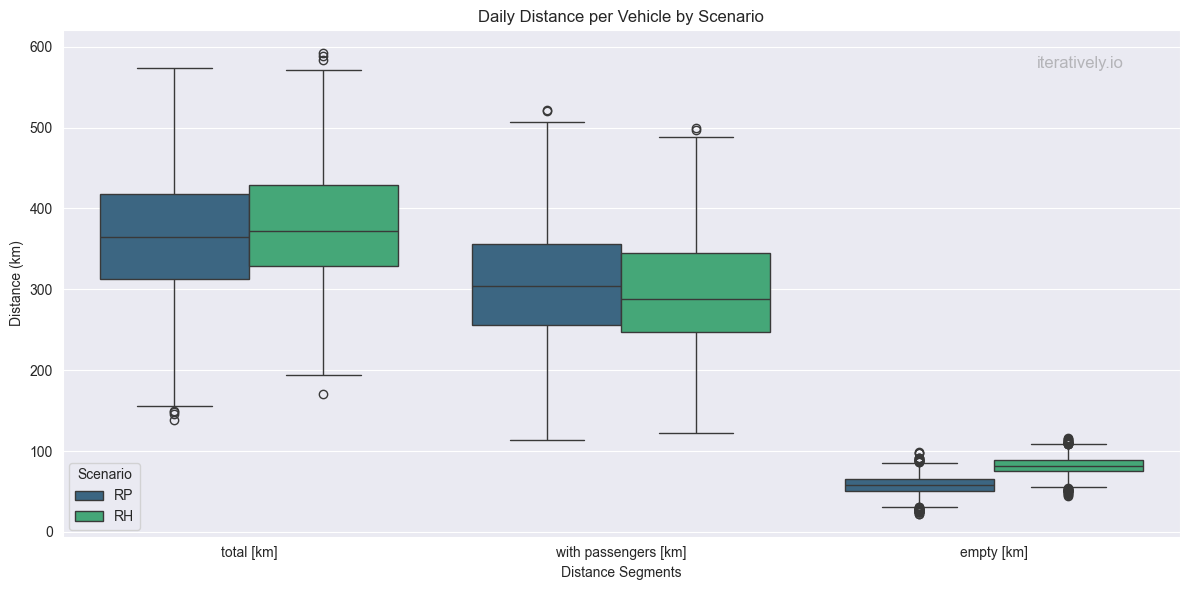

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os


scenarios = {
    "RP": "b8266bde-cfe8-4e4d-b59b-0965202de258",
    "RH": "0d95c633-2c12-4b99-bdf9-22b005e281c2"
}

base_path = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..", "outputs", "chicago", "output"))
file_name = "output_vehicleDistanceStats_drt.csv"


all_data = []


for label, uuid in scenarios.items():
    file_path = os.path.join(base_path, uuid, file_name)
    if not os.path.exists(file_path):
        print(f"Datei nicht gefunden: {file_path}")
        continue
    df = pd.read_csv(file_path, sep=';')
    df_km = df[['drivenDistance_m', 'occupiedDistance_m', 'emptyDistance_m']] / 1000 / 7
    df_km.columns = ['total [km]', 'with passengers [km]', 'empty [km]']
    df_km['Scenario'] = label
    all_data.append(df_km)


combined_df = pd.concat(all_data)


df_long = combined_df.melt(id_vars='Scenario', var_name='Distance Segments', value_name='Distance')


plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_long,
    x='Distance Segments',
    y='Distance',
    hue='Scenario',
    palette='viridis'
)


ax.set_title('Daily Distance per Vehicle by Scenario', fontsize=12)
ax.set_ylabel('Distance (km)', fontsize=10)
ax.tick_params(axis='both', labelsize=10)


ax.text(0.95, 0.95, 'iteratively.io', fontsize=12, color='gray', ha='right', va='top', alpha=0.5, transform=ax.transAxes)


plt.tight_layout()
plt.savefig("daily_distance_comparison.png")
plt.show()


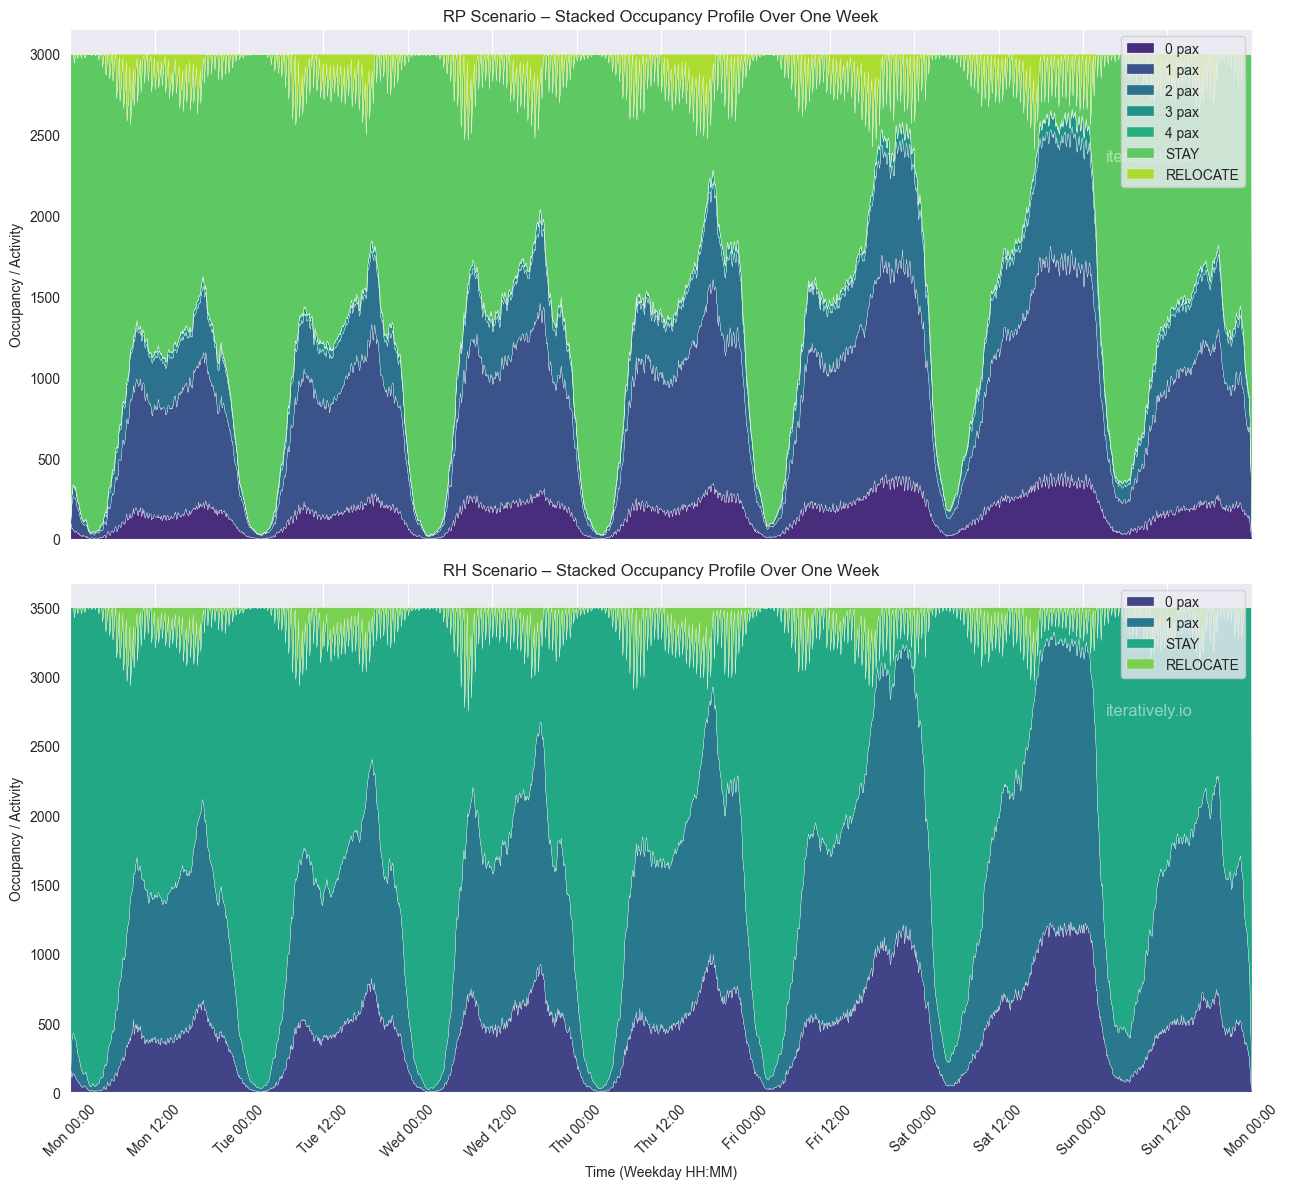

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import os
import locale
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')


scenarios = {
    "RP": "b8266bde-cfe8-4e4d-b59b-0965202de258",
    "RH": "0d95c633-2c12-4b99-bdf9-22b005e281c2"
}


scenario_categories = {
    "RP": ['0 pax', '1 pax', '2 pax', '3 pax', '4 pax', 'STAY', 'RELOCATE'],
    "RH": ['0 pax', '1 pax', 'STAY', 'RELOCATE']
}


start = pd.Timestamp('2025-06-02 00:00:00')


fig, axes = plt.subplots(nrows=len(scenarios), ncols=1, figsize=(13, 6 * len(scenarios)), sharex=True)

if len(scenarios) == 1:
    axes = [axes]

for ax, (label, uuid) in zip(axes, scenarios.items()):
    file_path = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..", "outputs", "chicago", "output", uuid, "ITERS", "it.2", "2.occupancy_time_profiles_drt.txt"))
    fleet = pd.read_csv(file_path, sep=';')
    fleet['datetime'] = pd.to_timedelta(fleet['time']) + start

    categories = scenario_categories[label]
    colors = sns.color_palette("viridis", n_colors=len(categories))
    stack_data = [fleet[cat] for cat in categories]

    ax.stackplot(fleet['datetime'], stack_data, labels=categories, colors=colors, linewidth=0.2)
    ax.set_title(f"{label} Scenario – Stacked Occupancy Profile Over One Week")
    ax.set_ylabel('Occupancy / Activity')
    ax.legend(loc='upper right')
    ax.grid(True)
    ax.text(0.95, 0.75, 'iteratively.io', fontsize=12, color='white', ha='right', va='center', transform=ax.transAxes, alpha=0.5)

    ax.set_xlim([fleet['datetime'].min(), fleet['datetime'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))


axes[-1].set_xlabel('Time (Weekday HH:MM)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("occupancy_stackplot_faceted.png")
plt.show()


TypeError: float() argument must be a string or a real number, not 'datetime.timedelta'

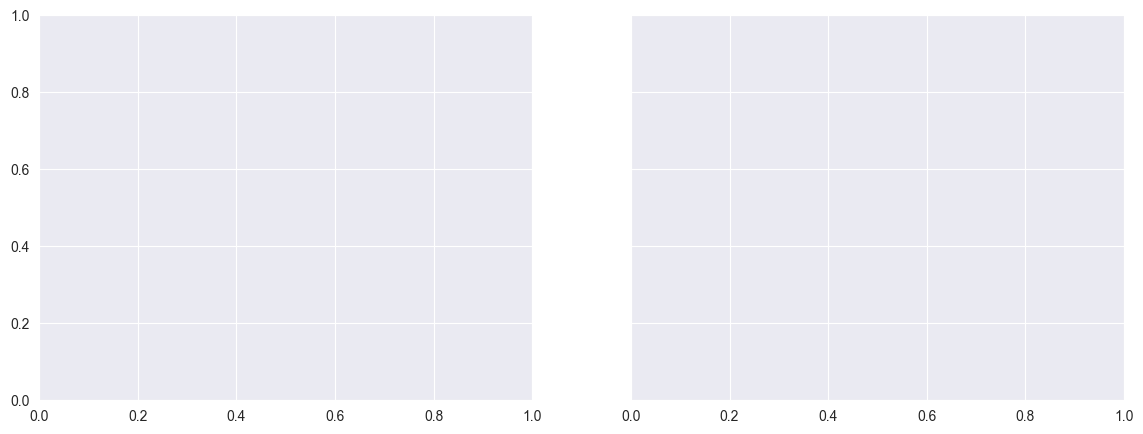

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Define scenarios and UUIDs
scenarios = {
    "RP": "b8266bde-cfe8-4e4d-b59b-0965202de258",
    "RH": "0d95c633-2c12-4b99-bdf9-22b005e281c2"
}

# Helper function to convert HH:MM:SS to seconds
def time_to_seconds(t):
    h, m, s = map(int, t.split(":"))
    return h * 3600 + m * 60 + s

# Rolling window parameters
window_size = 2 * 3600  # 2 hours
step_size = 600         # 10 minutes

# Plot setup
fig, axes = plt.subplots(nrows=1, ncols=len(scenarios), figsize=(14, 5), sharey=True)

for ax, (label, uuid) in zip(axes, scenarios.items()):
    # Construct file path
    file_path = os.path.abspath(os.path.join(
        os.getcwd(), "..", "..", "..", "..", "outputs", "chicago", "output",
        uuid, "output_trips.csv.gz"
    ))

    # Load data
    df = pd.read_csv(file_path, sep=";")
    df["dep_time_sec"] = df["dep_time"].apply(time_to_seconds)
    df["trav_time_sec"] = df["trav_time"].apply(time_to_seconds)

    # Rolling aggregation
    min_time = df["dep_time_sec"].min()
    max_time = df["dep_time_sec"].max()
    times = []
    means = []

    for t in range(min_time, max_time, step_size):
        window_start = t
        window_end = t + window_size
        window_data = df[(df["dep_time_sec"] >= window_start) & (df["dep_time_sec"] < window_end)]
        if not window_data.empty:
            times.append(t)
            means.append(window_data["trav_time_sec"].mean())

    # Plot 
    ax.plot([t.total_seconds() for t in times], means, label=f"{label} Avg. Travel Time")
    ax.set_title(f"{label} Scenario")
    ax.set_xlabel("Start time of 2h window")
    ax.grid(True)

axes[0].set_ylabel("Average Travel Time (seconds)")
plt.tight_layout()
plt.legend()
plt.show()
